# PH481 Astrophysics
### Assignment 2-2. The radial velocity of a binary star system over a time.
**Professor's Instruction:** <br/>
The orbital motion of binary stars can be analyzed through radial velocity measurements of each component. This YouTube video (https://www.youtube.com/watch?v=fWJ0S86hJt0) illustrates the concept. Write a script in Python (or your language of choice) to simulate and plot the radial velocity curves of a binary star system over time. In the referenced video, the argument of periapsis (ω) is 0.8, but you can use any arbitrary inclination angle for your simulation. Please include your script and the resulting plots showing the radial velocities of both stars over two complete orbits, similar to the style shown in the video. (50 pts)

<br/>

## 1. Packages
Below is the packages and default setting to get a plot. <br/>
For each package, refer to below documents for more information.
* `numpy`: A package for array handling, mathematical functions(log, sin, etc.). https://numpy.org/doc/stable/user/index.html#user
* `matplotlib`: A package for plotting curves. https://matplotlib.org/stable/users/index
* `astropy`: A package for astronomical calculation. https://docs.astropy.org/en/stable/index_user_docs.html

In [1]:
# import time
import sys
import numpy as np                                  # numpy
import matplotlib.pyplot as plt                     # matplotlib
from astropy import constants as const              # astropy
from IPython.display import clear_output
import matplotlib.animation as animation


## user may define the constant by themselves without using astropy.constants
# c = 3 * 10**(8)             # m / s
# G = 6.67 * 10**(-11)        # m^3 / (kg s^2)
# M_sun = 2 * 10**(30)        # kg
# au = 1.5 * 10**(11)         # m 


## To enable the interactive widgets (such as plots, animations).
%matplotlib widget 

## To print numpy array without truncation. This is useful to check the results.
np.set_printoptions(threshold=sys.maxsize)

## 2. Elliptical orbit

The radial distance of an elliptical orbit as a function of polar angle $\theta$ is
$$ r = \frac{a (1-e^2)}{1-e\cos{\theta}}. $$
Here, $a$ is semi-major axis and $e$ is an eccentricity of its orbit. Then $x$ and $y$ coordinate of the orbit is
$$ x = r \cos{\theta}, \qquad y = r \sin{\theta}. $$


Now we will compute the instantaneous velocity along $x$-ax1is (which is observer's direction), not explicitly but approximately since the data is discrete. When $\Delta t$ is sufficiently small,
$$ v_{x}(t) \simeq \frac{\Delta x}{\Delta t}. $$

In [2]:
## Orbit of ellipse with polar coordinate.
# Input| theta: array-like or float, polar angle / a: float, semi-major axis / e: float, eccentricity.
def ellipse(theta, a, e) :                              
    r = a * (1 - e**2) / (1 - e * np.cos(theta))
    return r 

## Instantaneous velocity of discrete position.
# Input| x_2d: array-like, position as a function of time.
def velocity_2d(x_2d) :                                 
    v_x = np.zeros(len(x_2d)-1)
    for i in range(1, len(x_2d)) :
        v_x[i-1] = (x_2d[i] - x_2d[i-1]) / delta_t      # Difference between position within small time interval
    return v_x

#### In 2-Dimensional space

In this case, we regard the inclination ($i$) and longitude of ascending node ($\Omega$), but only the argument of periapsis ($\omega$) matters. When $x$ and $y$ are the initial coordinate ($\omega=0$) of the star, the new coordinate $x'$ and $y'$ is
$$ \begin{pmatrix} 
    x' \\ y'
\end{pmatrix} = 
\begin{pmatrix}
    \cos{\omega} & -\sin{\omega} \\ \sin{\omega} & \cos{\omega}
\end{pmatrix}
\begin{pmatrix}
    x \\ y
\end{pmatrix}, $$
$$ \begin{align}
    x' &= x \cos{\omega} - y \sin{\omega} \\
    y' &= x \sin{\omega} + y \sin{\omega} \\
\end{align}$$

In [3]:
## x, y coordinate after rotation of omega (argument of periapsis)
# Input| x: array-like or float, x-coordinate / y: array-like or float, y-coordinate / omega: float(radian), argument of periapsis
def rotation_2d(x, y, omega) :
    temp_x = x * np.cos(omega) - y * np.sin(omega)
    temp_y = x * np.sin(omega) + y * np.sin(omega)
    return temp_x, temp_y

### 2.1. Initial condition

In [4]:
## Mass related parameters
m_1 = 2                                         # Mass of star_1 (heavier) - unit: solarmass
m_2 = 1                                         # Mass of star_2 (lighter) - unit: solarmass
M_T = m_1 + m_2                                 # Total mass
mu = m_1 * m_2 / M_T                            # Reduced mass

## Orbit related parameters
e = 0.7                                         # Eccentricity of the orbits
a_s = 1                                         # Semi-major ax1is of reduced orbit - unit: AU
b_s = a_s * np.sqrt(1 - e**2)                   # Semi-minor ax1is of reduced orbit - unit: AU
a_1 = a_s * m_2/M_T                             # Semi-major ax1is of star_1 - unit: AU
a_2 = a_s * m_1/M_T                             # Semi-major ax1is of star_2 - unit: AU


## Time related parameters
P = 2 * np.pi * np.sqrt(a_s**3 / M_T)           # Period of the orbit.
delta_t = P/1000                                # Small time interval that we will use to calculate the position & velocity of stars.
arr_t = np.arange(0, 2*P, delta_t)              # Range of time, equivalent with the period times 2.

### 2.2. Calculate $x$, $y$ coordinate as a function of time.

$$ G M_{tot} P^2 = 4 \pi^2 a_s^3, \quad \Rightarrow \quad P = 2 \pi \sqrt{\frac{a_s^3}{G M_{tot}}}. $$
$$ \frac{dA}{dt} = \frac{\pi a_s b_s}{P} = \frac{b_s}{2} \sqrt{\frac{G M_{tot}}{a_s}} = \frac{1}{2} s^2 \frac{d \theta}{dt}, $$
$$ \frac{d \theta}{dt} = \sqrt{G M_{tot} a_s (1 - e^2)} \frac{1}{s^2} = \frac{k}{s^2}, \quad \text{where }\ k \equiv \sqrt{G M_{tot} a_s (1 - e^2)},  $$
$$ \Rightarrow d \theta = \frac{k}{s^2} dt $$

In [5]:
## define a initial distance as a function of time
s_time = [ellipse(0, a_s, e)]                   # Absolute value of radial distance of reduced system as a function of time.
r_1_time = [ellipse(0, a_1, e)]                 # Absolute value of radial distance of star_1 as a function of time.
r_2_time = [ellipse(np.pi, a_2, -e)]            # Absolute value of radial distance of star_2 as a function of time.
theta_time = [0]                                # Polar angle of the system as a function of time.


# Calculate the radial distance and the polar angle as a function of time. Refer to above equation.
k = np.sqrt(M_T * a_s * (1 - e**2)) 
for i in range(len(arr_t)-1) :
    delta_theta = delta_t * k / s_time[-1]**2
    theta_time.append(theta_time[-1] + delta_theta)
    s_time.append(ellipse(theta_time[-1], a_s, e))
    r_1_time.append(ellipse(theta_time[-1], a_1, e))
    r_2_time.append(ellipse(theta_time[-1] + np.pi, a_2, -e))

# convert the list as a numpy array.
s_time = np.array(s_time)
r_1_time = np.array(r_1_time)                   
r_2_time = np.array(r_2_time)                   
theta_time = np.array(theta_time)

# convert r, theta as x, y.
x_1, y_1 = r_1_time * np.cos(theta_time), r_1_time * np.sin(theta_time)
x_2, y_2 = r_2_time * np.cos(theta_time + np.pi), r_2_time * np.sin(theta_time + np.pi)

# Compute the x, y coordinate when the argument of periapsis is non zero.
omega = 0.5
x_1_2d, y_1_2d = rotation_2d(x_1, y_1, omega)
x_2_2d, y_2_2d = rotation_2d(x_2, y_2, omega)

# Compute the velocity at each position.
v_1 = velocity_2d(x_1_2d)
v_2 = velocity_2d(x_2_2d)

### 2.3. Animation for the elliptical orbit.

In [6]:
def animation_2d_rotation(x_1, y_1, x_2, y_2, output_pwd) :
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(1, 1, 1)

    # Move left y-ax1is and bottom x-ax1is to pass through (0,0). Remove top and right ax1is.
    ax1.spines['left'].set_position('zero')
    ax1.spines['bottom'].set_position('zero')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Set the scale of both ax1is to be same.
    ax1.set_aspect('equal')              


    # Plot the trajectory of ellipse. / Red - star_1, Blue - star_2.
    plt.plot(x_1, y_1, 'r-')
    plt.plot(x_2, y_2, 'b-')
    plt.xlabel(r'$x$', loc='right')
    plt.ylabel(r'$y$', loc='top')

    # Plot the observer's direction.
    plt.arrow(x=0, y=0, dx=plt.xlim()[1], dy=0, color='black', width=0.005, head_width=(plt.ylim()[1]-plt.ylim()[0])/50, length_includes_head=True, label="Observer")

    # Make an empty plot to point out the location of each star.
    xy_1, = ax1.plot([], [], 'r.', markersize=10*m_1, label=r"Star 1 ($m_1$ = {})".format(m_1))
    xy_2, = ax1.plot([], [], 'b.', markersize=10*m_2, label=r"Star 2 ($m_2$ = {})".format(m_2))
    plt.legend(loc='upper left')


    # Update the location of each star frame by frame.
    def update(frame) :
        xy_1.set_data(x_1[frame], y_1[frame])
        xy_2.set_data(x_2[frame], y_2[frame])
        return xy_1, xy_2

    # Generate the animation.
    ani = animation.FuncAnimation(fig=fig, func=update, frames=len(arr_t)-1, interval=0.0001)
    # ani.save(filename="/Users/jungeun/Desktop/24-2/PH481/HW2/test.mp4",  dpi=300, writer=animation.FFMpegWriter(fps=30))
    # ani.save(filename=output_pwd, dpi=300, writer=animation.PillowWriter(fps=45))
    plt.show()

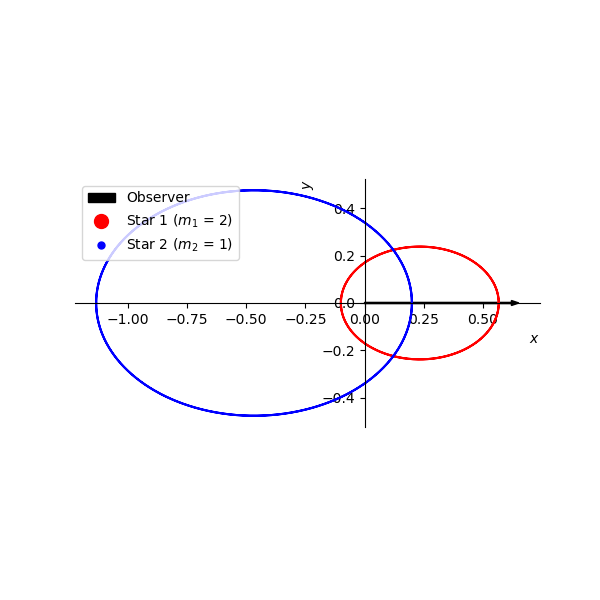

In [7]:
## Test ##
output_pwd = "/Users/jungeun/Desktop/24-2/PH481/HW2/test_1.gif"
animation_2d_rotation(x_1, y_1, x_2, y_2, output_pwd)

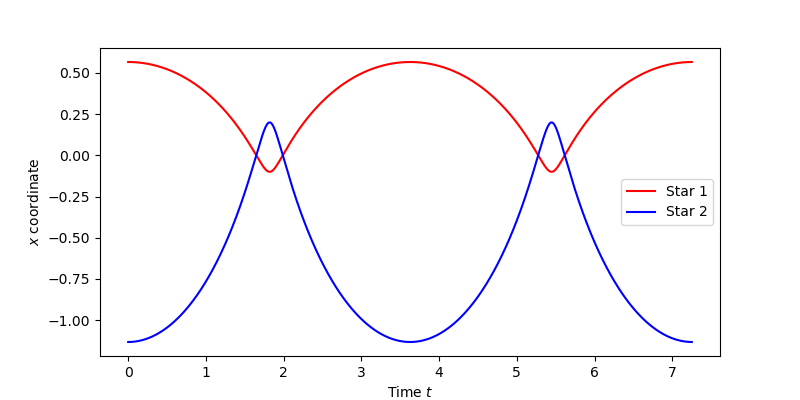

In [8]:
## Test ##
fig = plt.figure(figsize=(8, 4))
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x$ coordinate')
plt.plot(arr_t, x_1, c='r', label='Star 1')
plt.plot(arr_t, x_2, c='b', label='Star 2')
plt.legend()
plt.show()

## 4. Radial velocity

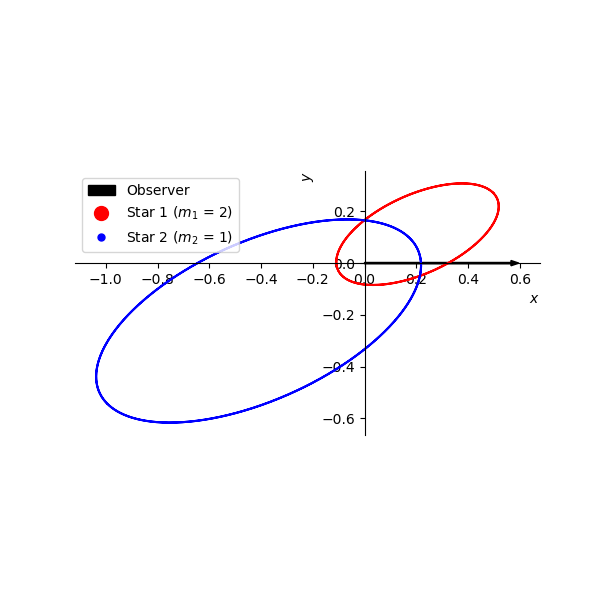

In [16]:
## Test ##
omega = 0.5

x_1_2d, y_1_2d = rotation_2d(x_1, y_1, omega)
x_2_2d, y_2_2d = rotation_2d(x_2, y_2, omega)

output_pwd = "/Users/jungeun/Desktop/24-2/PH481/HW2/test_2.gif"
animation_2d_rotation(x_1_2d, y_1_2d, x_2_2d, y_2_2d, output_pwd)

/Users/jungeun/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


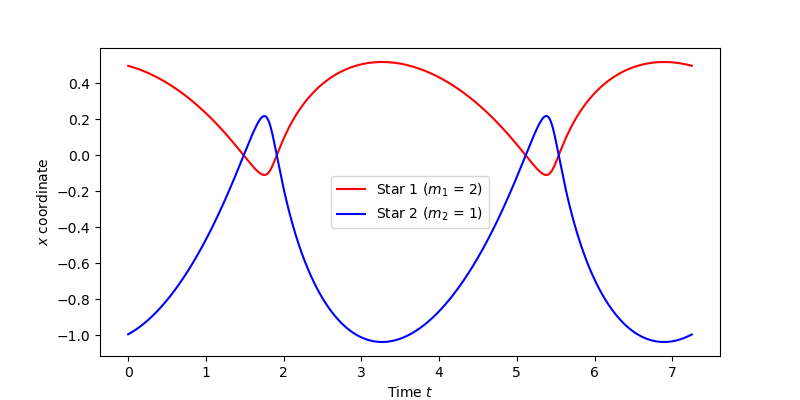

In [11]:
## Test ##
fig = plt.figure(figsize=(8, 4))
plt.xlabel(r'Time $t$')
plt.ylabel(r'$x$ coordinate')
plt.plot(arr_t, x_1_2d, c='r', label=r"Star 1 ($m_1$ = {})".format(m_1))
plt.plot(arr_t, x_2_2d, c='b', label=r"Star 2 ($m_2$ = {})".format(m_2))
plt.legend()
plt.show()

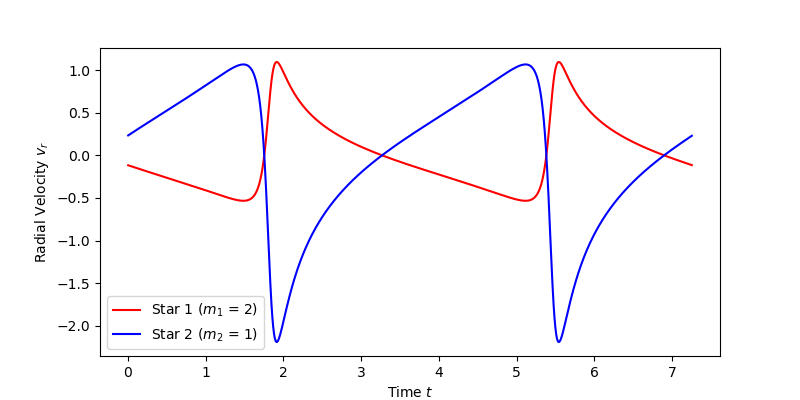

In [13]:
fig = plt.figure(figsize=(8, 4))
plt.xlabel(r'Time $t$')
plt.ylabel(r'Radial Velocity $v_r$')
plt.plot(arr_t[1:], v_1, c='r', label=r"Star 1 ($m_1$ = {})".format(m_1))
plt.plot(arr_t[1:], v_2, c='b', label=r"Star 2 ($m_2$ = {})".format(m_2))
plt.legend()
plt.show()

### 4.1. Animation for radial velocity

In [14]:
def animation_2d_rotation_w_velocity(x_1, y_1, x_2, y_2, v_1, v_2, arr_t, output_pwd) :
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # Move left y-ax1is and bottom x-ax1is to pass through (0,0). Remove top and right ax1is.
    ax1.spines['left'].set_position('zero')
    ax1.spines['bottom'].set_position('zero')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Set the scale of both ax1is to be same.
    ax1.set_aspect('equal')              


    # Plot the trajectory of ellipse. / Red - star_1, Blue - star_2.
    ax1.plot(x_1, y_1, 'r-')
    ax1.plot(x_2, y_2, 'b-')
    ax1.set_xlabel(r'$x$', loc='right')
    ax1.set_ylabel(r'$y$', loc='top')

    # Plot the observer's direction.
    ax1.arrow(x=0, y=0, dx=plt.xlim()[1], dy=0, color='black', width=0.005, head_width=(plt.ylim()[1]-plt.ylim()[0])/50, length_includes_head=True, label="Observer")


    ax2.plot(arr_t[1:], v_1, c='r')
    ax2.plot(arr_t[1:], v_2, c='b')
    ax2.set_xlabel(r'Time $t$')
    ax2.set_ylabel(r'Radial Velocity $v_r$')
    plt.legend()



    # Make an empty plot to point out the location of each star.
    xy_1, = ax1.plot([], [], 'r.', markersize=10*m_1, label=r"Star 1 ($m_1$ = {})".format(m_1))
    xy_2, = ax1.plot([], [], 'b.', markersize=10*m_2, label=r"Star 2 ($m_2$ = {})".format(m_2))
    tv_1, = ax2.plot([], [], 'r.', markersize=10*m_1, label=r"Star 1 ($m_1$ = {})".format(m_1))
    tv_2, = ax2.plot([], [], 'b.', markersize=10*m_2, label=r"Star 2 ($m_2$ = {})".format(m_2))
    ax1.legend(loc='upper left')


    # Update the location of each star frame by frame.
    def update(frame) :
        xy_1.set_data(x_1[frame], y_1[frame])
        xy_2.set_data(x_2[frame], y_2[frame])
        tv_1.set_data(arr_t[frame], v_1[frame])
        tv_2.set_data(arr_t[frame], v_2[frame])
        return xy_1, xy_2, tv_1, tv_2

    # Generate the animation.
    ani = animation.FuncAnimation(fig=fig, func=update, frames=len(arr_t)-1, interval=0.0001)
    # ani.save(filename="/Users/jungeun/Desktop/24-2/PH481/HW2/test.mp4",  dpi=300, writer=animation.FFMpegWriter(fps=30))
    ani.save(filename=output_pwd, dpi=300, writer=animation.PillowWriter(fps=45))
    # plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


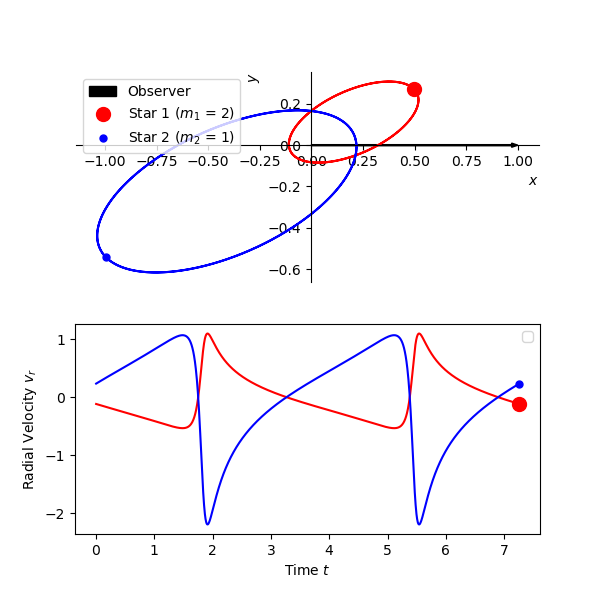

In [15]:
output_pwd = "/Users/jungeun/Desktop/24-2/PH481/HW2/test_3.gif"
animation_2d_rotation_w_velocity(x_1_2d, y_1_2d, x_2_2d, y_2_2d, v_1, v_2, arr_t, output_pwd)